En este notebook se realizará la implementación de un modelo de regresión lineal o multiple para predecir el rendimiento de un cultivo con base a diferentes
varaibles predictoras.

In [1]:
# Importar librerias

In [1]:
import pandas as pd
import geopandas as gpd
import os
from pathlib import PurePath
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

## Cargar datos

In [2]:
vis_22 = r"C:\Users\Isai\Documents\Tesis\code\data_analysis\all_vars\zafra2022"
gdf = gpd.read_file(r"C:\Users\Isai\Documents\Tesis\code\Parcelas\poligonos_parcelas.geojson")

In [3]:
vis_df = pd.DataFrame(columns=[
    'parcela',
    'vis_value',
    'precip',
    'etc', 
    'dias'
])

In [4]:
for i in os.listdir(vis_22):
    if i.endswith('.csv'):
        df = pd.read_csv(PurePath(vis_22, i))
        df['Fecha'] = pd.to_datetime(df['Fecha'])
        parcela_id = int(i.split('_')[1].split('.')[0])
        id_max_value = df['ndvi'].idxmax()
        date_max_value = df.loc[id_max_value, 'Fecha']
        print(parcela_id, date_max_value)
        vis_value = df.loc[id_max_value, 'ndvi']
        lluvia = df.loc[id_max_value, 'precip_acum']
        etc_acum = df['etc'].sum()
        days = (date_max_value - df['Fecha'].min()).days
        
        
        vis_df = vis_df._append({
            'parcela': parcela_id,
            'vis_value': vis_value,
            'precip': lluvia,
            'etc': etc_acum,
            'dias': days
        }, ignore_index=True)

1 2022-10-25 00:00:00
10 2022-10-13 00:00:00
11 2022-09-30 00:00:00
13 2022-11-13 00:00:00
14 2022-11-19 00:00:00
15 2022-11-25 00:00:00
16 2022-11-16 00:00:00
2 2022-11-22 00:00:00
3 2022-10-11 00:00:00
4 2022-11-28 00:00:00
5 2022-11-06 00:00:00
6 2022-12-08 00:00:00
7 2022-09-29 00:00:00
8 2022-12-05 00:00:00
9 2022-12-07 00:00:00


C:\Users\Isai\AppData\Local\Temp\ipykernel_9076\1799128995.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  vis_df = vis_df._append({


In [5]:
merged_df = pd.merge(gdf, vis_df, left_on='Id', right_on='parcela', how='inner')

In [6]:
merged_df.drop(columns=['Productor', 'Ciclo', 'Riego', 'Variedad', 'Siembra', 'Cosecha', 'geometry'], inplace=True)

In [7]:
merged_df.corr(method='pearson')

,Id,Rendimiento,parcela,vis_value,precip,etc,dias
Id,1.000000,-0.244834,1.000000,-0.213486,0.179818,-0.251858,0.097254
Rendimiento,-0.244834,1.000000,-0.244834,0.895832,-0.530568,0.612164,-0.060357
parcela,1.000000,-0.244834,1.000000,-0.213486,0.179818,-0.251858,0.097254
vis_value,-0.213486,0.895832,-0.213486,1.000000,-0.433723,0.427193,0.014450
precip,0.179818,-0.530568,0.179818,-0.433723,1.000000,-0.502967,0.206619
etc,-0.251858,0.612164,-0.251858,0.427193,-0.502967,1.000000,0.508103
dias,0.097254,-0.060357,0.097254,0.014450,0.206619,0.508103,1.000000


## Modelo de regresión lineal

In [8]:
X = merged_df[['etc', 'vis_value']]
y = merged_df['Rendimiento']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train = sm.add_constant(X_train)

In [11]:
model = sm.OLS(y_train, X_train).fit()

In [12]:
model.summary()

C:\Users\Isai\Documents\Tesis\code\.venv\Lib\site-packages\scipy\stats\_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  k, _ = kurtosistest(a, axis)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Rendimiento   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     25.20
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           0.000205
Time:                        12:03:04   Log-Likelihood:                -38.766
No. Observations:                  12   AIC:                             83.53
Df Residuals:                       9   BIC:                             84.99
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -144.9187     29.582     -4.899      0.001    -211.837     -78.001
etc            0.0238      0.018      1.323      0.219      -0.017       0.064
vis_value    237.7525     40.874      5.817      0.000     145.288     330.217
==============================================================================
Omnibus:                        0.077   Durbin-Watson:                   1.526
Prob(Omnibus):                  0.962   Jarque-Bera (JB):                0.263
Skew:                          -0.139   Prob(JB):                        0.877
Kurtosis:                       2.330   Cond. No.                     2.93e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.93e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)

In [14]:
print(model.mse_total)

269.69696969696963


In [15]:
mean_squared_error(model.predict(sm.add_constant(X)), y)

39.994303496456126

In [16]:
mse(y, model.predict(sm.add_constant(X)))

39.994303496456126

In [17]:
rmse(y, model.predict(sm.add_constant(X)))

6.3241049561543585

In [18]:
data = pd.DataFrame({
    'y': y,
    'y_pred': model.predict(sm.add_constant(X))
})

In [19]:
data

,y,y_pred
0,48,39.917070
1,60,67.379436
2,45,46.712456
3,50,61.969981
4,75,72.976432
5,75,67.101842
6,75,77.872729
7,75,65.904099
8,75,66.746218
9,75,73.121224


In [20]:
merged_df['pred'] = model.predict(sm.add_constant(X))

In [21]:
merged_df.describe()

,Id,Rendimiento,parcela,vis_value,precip,etc,dias,pred
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,8.266667,59.533333,8.266667,0.733121,575.406667,1265.134257,225.800000,59.471416
std,4.832430,17.455522,4.832430,0.060164,21.304100,135.521656,21.247521,15.949608
min,1.000000,25.000000,1.000000,0.597182,547.350000,1063.731786,198.000000,22.723167
25%,4.500000,49.000000,4.500000,0.686278,561.465000,1169.420565,207.000000,49.237575
50%,8.000000,60.000000,8.000000,0.767247,572.840000,1231.884026,223.000000,65.904099
75%,12.000000,75.000000,12.000000,0.773196,592.425000,1375.347214,241.500000,70.177934
max,16.000000,75.000000,16.000000,0.791956,613.870000,1471.880669,262.000000,77.872729


In [27]:
merged_df

,Id,Rendimiento,parcela,vis_value,precip,etc,dias,pred
0,1,48,1.0,0.645529,582.23,1318.566277,222.0,39.917070
1,2,60,2.0,0.775832,564.31,1170.671495,205.0,67.379436
2,3,45,3.0,0.676195,547.55,1297.730937,223.0,46.712456
3,4,50,4.0,0.753330,613.87,1168.169636,256.0,61.969981
4,5,75,5.0,0.772565,588.12,1438.664551,229.0,72.976432
5,6,75,6.0,0.768541,573.43,1231.884026,206.0,67.101842
6,7,75,7.0,0.791956,547.35,1450.693650,241.0,77.872729
7,8,75,8.0,0.767247,571.98,1194.453985,198.0,65.904099
8,9,75,9.0,0.771219,572.84,1190.157430,200.0,66.746218
9,10,75,10.0,0.773828,558.62,1432.128150,255.0,73.121224


<Figure size 1200x1200 with 0 Axes>

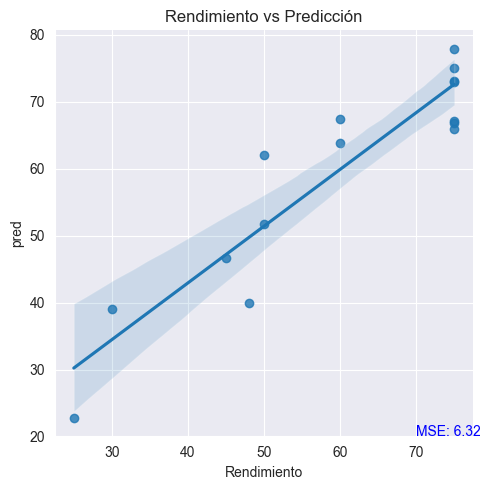

In [41]:
plt.figure(figsize=(12, 12))
sns.lmplot(x='Rendimiento', y='pred', data=merged_df)
plt.title('Rendimiento vs Predicción')
plt.text(70, 20, f'MSE: {rmse(y, model.predict(sm.add_constant(X))):.2f}', color='b')
plt.savefig(PurePath(r"C:\Users\Isai\Documents\Tesis\code\revision\img\2022\rendimiento", 'rendimiento_vs_pred.png'), dpi=300)
plt.tight_layout()
plt.show()

In [23]:
par4 = pd.read_csv(r'C:\Users\Isai\Documents\Tesis\code\datos\parcelas\indices_stats_cleaned\parcela_4.csv')

In [24]:
par4['Fecha'] = pd.to_datetime(par4['Fecha'])

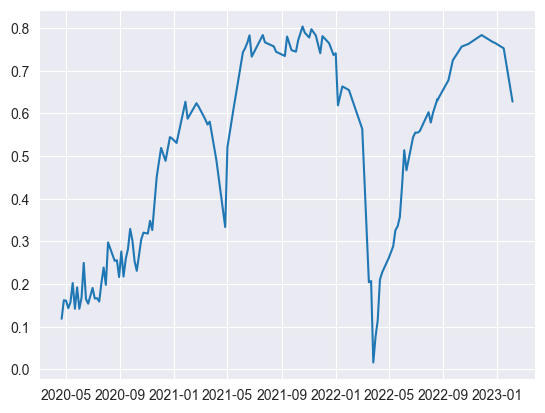

In [25]:
plt.plot(par4['Fecha'], par4['ndvi_mean'])